# Análisis Exploratorio de Datos (EDA) - MI-EEG

Este notebook realiza un análisis exploratorio completo de los datos de imaginación motora (MI) usando EEGLAB, incluyendo:

1. **Análisis espectral (PSD)**: Densidad espectral de potencia en bandas μ/β
2. **Correlación intercanal**: Análisis de conectividad entre canales EEG
3. **Visualizaciones**: Gráficos y mapas de calor para interpretación

## Objetivos
- Analizar características espectrales de las señales EEG
- Identificar patrones de correlación entre regiones cerebrales
- Preparar datos para análisis posteriores con wavelets


In [14]:
# Celda de instalación de dependencias
# Ejecutar esta celda SOLO si necesitas instalar las librerías en un entorno nuevo

#%pip install mne
#%pip install PyWavelets
#%pip install scikit-learn
#%pip install matplotlib
#%pip install pandas
#%pip install numpy
#%pip install scipy
#%pip install tqdm

print("Instalación de dependencias completada")


Instalación de dependencias completada


In [5]:
# Importar librerías necesarias
import os
import re
from glob import glob
from pathlib import Path
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
from mne.io import read_raw_eeglab
from scipy.signal import welch

# Configurar matplotlib para mejor visualización
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.style.use('seaborn-v0_8')

print("Librerías importadas correctamente")


Librerías importadas correctamente


## Configuración de Parámetros

Definimos los parámetros principales para el análisis:


In [6]:
# Parámetros de análisis
LOW_BAND, HIGH_BAND = 8.0, 30.0  # Rango de frecuencias de interés
MU_BAND = (10.0, 12.0)           # Banda mu (ritmo sensoriomotor)
BETA_BAND = (18.0, 26.0)         # Banda beta
EXPECTED_TRIAL_SEC = 9.0         # Duración esperada de cada trial

# Directorios de datos
CANDIDATE_DIRS = {
    "left_imag":  ("left",  "imag"),
    "right_imag": ("right", "imag"),
}

# Regiones cerebrales por prefijos del sistema 10-20
REGION_PREFIXES = {
    "F" : ("Fp", "AF", "F"),    # Frontal
    "FC": ("FC",),              # Frontocentral
    "C" : ("C", "Cz"),          # Central
    "CP": ("CP",),              # Centroparietal
    "P" : ("P",),               # Parietal
    "PO": ("PO",),              # Parietooccipital
    "O" : ("O",),               # Occipital
}

# Configuración de directorios
data_root = Path(".").resolve()  # Directorio actual
output_dir = Path("results/eda")  # Cambiado a estructura unificada
output_dir.mkdir(parents=True, exist_ok=True)

print(f"Directorio de datos: {data_root}")
print(f"Directorio de salida: {output_dir.resolve()}")
print(f"Bandas de frecuencia: {LOW_BAND}-{HIGH_BAND} Hz")
print(f"Banda μ: {MU_BAND[0]}-{MU_BAND[1]} Hz")
print(f"Banda β: {BETA_BAND[0]}-{BETA_BAND[1]} Hz")


Directorio de datos: /Users/manueljurado/Downloads/datos_BCI
Directorio de salida: /Users/manueljurado/Downloads/datos_BCI/results/eda
Bandas de frecuencia: 8.0-30.0 Hz
Banda μ: 10.0-12.0 Hz
Banda β: 18.0-26.0 Hz


## Funciones Auxiliares

Definimos las funciones necesarias para el procesamiento de datos:


In [7]:
def subject_from_fname(fname: str) -> str:
    """Extrae el ID del sujeto del nombre del archivo."""
    m = re.search(r"(S\d{3})", os.path.basename(fname))
    return m.group(1) if m else os.path.basename(fname)

def try_read_epochs(fname: str) -> mne.BaseEpochs:
    """Lee epochs de EEGLAB, creando epochs si es necesario."""
    # 1) Si ya viene epocado
    try:
        ep = mne.read_epochs_eeglab(fname, verbose="ERROR")
        _ = ep.get_data()
        return ep
    except Exception:
        pass
    
    # 2) Continuo -> ventaneo simple de 9s
    raw = read_raw_eeglab(fname, preload=True, verbose="ERROR")
    try:
        raw.filter(LOW_BAND, HIGH_BAND, verbose="ERROR")
    except Exception:
        pass
    
    sfreq = float(raw.info["sfreq"])
    n_win = int(np.floor(raw.times[-1] / EXPECTED_TRIAL_SEC))
    if n_win < 1:
        data = np.expand_dims(raw.get_data(), axis=0)
        return mne.EpochsArray(data, raw.info, tmin=0.0, verbose="ERROR")
    
    picks = mne.pick_types(raw.info, eeg=True, meg=False, stim=False, eog=False)
    samps = int(EXPECTED_TRIAL_SEC * sfreq)
    data_list: List[np.ndarray] = []
    
    for i in range(n_win):
        s, e = i * samps, (i + 1) * samps
        if e <= raw.n_times:
            data_list.append(np.expand_dims(raw.get_data(picks=picks)[:, s:e], axis=0))
    
    data = np.concatenate(data_list, axis=0)
    info = mne.create_info([raw.ch_names[p] for p in picks], sfreq, ch_types="eeg")
    return mne.EpochsArray(data, info, tmin=0.0, verbose="ERROR")

def band_mask(freqs: np.ndarray, fmin: float, fmax: float) -> np.ndarray:
    """Crea máscara para rango de frecuencias."""
    return (freqs >= fmin) & (freqs <= fmax)

print("Funciones auxiliares definidas")


Funciones auxiliares definidas


## Carga de Datos

Cargamos todos los archivos de datos de imaginación motora (left/right):


In [8]:
# Cargar epochs de imaginación (left/right)
epochs_list: List[mne.BaseEpochs] = []
subjects_info = []

print("Cargando datos de imaginación motora...")

for dirname in ["left_imag", "right_imag"]:
    dpath = data_root / dirname
    if not dpath.is_dir():
        print(f"Advertencia: No existe {dpath}, omitiendo...")
        continue
    
    print(f"Procesando directorio: {dirname}")
    files_processed = 0
    
    for set_path in sorted(glob(str(dpath / "*.set"))):
        try:
            subject_id = subject_from_fname(set_path)
            ep = try_read_epochs(set_path)
            epochs_list.append(ep)
            subjects_info.append({
                'subject': subject_id,
                'task': dirname.split('_')[0],  # 'left' o 'right'
                'file': set_path,
                'n_trials': ep.get_data().shape[0]
            })
            files_processed += 1
            print(f"  {subject_id}: {ep.get_data().shape[0]} trials")
        except Exception as e:
            print(f"  Error en {set_path}: {e}")

print(f"\nResumen de carga:")
print(f"  - Archivos procesados: {files_processed}")
print(f"  - Total de epochs: {len(epochs_list)}")

if not epochs_list:
    print("Error: No se cargaron epochs. Verificar archivos de datos.")
else:
    print("Datos cargados correctamente")


Cargando datos de imaginación motora...
Procesando directorio: left_imag
  S001: 22 trials
  S002: 22 trials
  S003: 23 trials
  S004: 23 trials
  S005: 21 trials
  S006: 23 trials
  S007: 22 trials
  S008: 22 trials
  S009: 23 trials
  S010: 23 trials
  S011: 23 trials
  S012: 21 trials
  S013: 22 trials
  S014: 22 trials
  S015: 22 trials
  S016: 21 trials
  S017: 22 trials
  S018: 21 trials
  S019: 22 trials
  S020: 22 trials
Procesando directorio: right_imag
  S001: 22 trials
  S002: 22 trials
  S003: 21 trials
  S004: 21 trials
  S005: 23 trials
  S006: 21 trials
  S007: 22 trials
  S008: 22 trials
  S009: 21 trials
  S010: 21 trials
  S011: 21 trials
  S012: 23 trials
  S013: 22 trials
  S014: 22 trials
  S015: 22 trials
  S016: 23 trials
  S017: 22 trials
  S018: 23 trials
  S019: 22 trials
  S020: 22 trials

Resumen de carga:
  - Archivos procesados: 20
  - Total de epochs: 40
Datos cargados correctamente


## Preparación de Datos

Concatenamos todos los epochs y verificamos la consistencia de los datos:


In [19]:
# Concatenar epochs y verificar consistencia
base_info = epochs_list[0].info
ch_names = epochs_list[0].ch_names
sfreq = float(epochs_list[0].info["sfreq"])

print(f"Información de los datos:")
print(f"  - Canales: {len(ch_names)}")
print(f"  - Frecuencia de muestreo: {sfreq} Hz")
print(f"  - Primeros 10 canales: {ch_names[:10]}")

# Verificar consistencia entre archivos
for i, ep in enumerate(epochs_list[1:], 1):
    if ep.ch_names != ch_names:
        print(f"Advertencia: Los órdenes de canales difieren en archivo {i}")
    if int(ep.info["sfreq"]) != int(sfreq):
        print(f"Advertencia: sfreq inconsistente en archivo {i}")

# Concatenar todos los datos
X = np.concatenate([ep.get_data() for ep in epochs_list], axis=0)  # (N, ch, T)
N, C, T = X.shape

print(f"\nDatos concatenados:")
print(f"  - Trials totales: {N}")
print(f"  - Canales: {C}")
print(f"  - Muestras por trial: {T}")
print(f"  - Duración por trial: {T/sfreq:.1f} segundos")

# Preparar datos para análisis espectral
data_concat = X.transpose(1, 0, 2).reshape(C, N * T)  # (ch, N*T)
print(f"  - Datos concatenados para PSD: {data_concat.shape}")


Información de los datos:
  - Canales: 64
  - Frecuencia de muestreo: 128.0 Hz
  - Primeros 10 canales: ['FC5', 'FC3', 'FC1', 'FCZ', 'FC2', 'FC4', 'FC6', 'C5', 'C3', 'C1']

Datos concatenados:
  - Trials totales: 880
  - Canales: 64
  - Muestras por trial: 1152
  - Duración por trial: 9.0 segundos
  - Datos concatenados para PSD: (64, 1013760)


## Análisis Espectral (PSD)

Calculamos la densidad espectral de potencia usando el método de Welch:


In [20]:
# Calcular PSD usando método de Welch
print(" Calculando PSD usando método de Welch...")

nperseg = int(sfreq * 2.0)     # 2 segundos por segmento
noverlap = int(nperseg * 0.5)  # 50% overlap

print(f"  - Segmentos de {nperseg} muestras ({nperseg/sfreq:.1f}s)")
print(f"  - Overlap del {noverlap/nperseg*100:.0f}%")

freqs, psd = welch(data_concat, fs=sfreq, nperseg=nperseg, noverlap=noverlap, axis=1)
print(f"  - Frecuencias calculadas: {len(freqs)} puntos")
print(f"  - Rango de frecuencias: {freqs[0]:.1f} - {freqs[-1]:.1f} Hz")

# Filtrar a rango de interés (8-30 Hz)
mask_830 = band_mask(freqs, LOW_BAND, HIGH_BAND)
freqs_filt = freqs[mask_830]
psd_filt = psd[:, mask_830]

print(f"\n PSD filtrado:")
print(f"  - Frecuencias en rango {LOW_BAND}-{HIGH_BAND} Hz: {len(freqs_filt)}")
print(f"  - Resolución espectral: {(freqs_filt[1] - freqs_filt[0]):.2f} Hz")
print(f"  - Forma de datos: {psd_filt.shape}")

# Calcular potencia promedio por banda μ/β
mu_mask = band_mask(freqs_filt, *MU_BAND)
be_mask = band_mask(freqs_filt, *BETA_BAND)

mu_power = psd_filt[:, mu_mask].mean(axis=1)
be_power = psd_filt[:, be_mask].mean(axis=1)

print(f"\n Potencia por banda:")
print(f"  - Banda μ ({MU_BAND[0]}-{MU_BAND[1]} Hz): {mu_power.mean():.2e} ± {mu_power.std():.2e}")
print(f"  - Banda β ({BETA_BAND[0]}-{BETA_BAND[1]} Hz): {be_power.mean():.2e} ± {be_power.std():.2e}")


 Calculando PSD usando método de Welch...
  - Segmentos de 256 muestras (2.0s)
  - Overlap del 50%
  - Frecuencias calculadas: 129 puntos
  - Rango de frecuencias: 0.0 - 64.0 Hz

 PSD filtrado:
  - Frecuencias en rango 8.0-30.0 Hz: 45
  - Resolución espectral: 0.50 Hz
  - Forma de datos: (64, 45)

 Potencia por banda:
  - Banda μ (10.0-12.0 Hz): 3.46e-12 ± 1.13e-12
  - Banda β (18.0-26.0 Hz): 2.09e-12 ± 8.38e-13


## Análisis de Picos Espectrales

Identificamos los picos de potencia en las bandas μ y β:


In [21]:
# Función para encontrar picos en bandas específicas
def peak_in_band(power_row: np.ndarray, faxis: np.ndarray, mask: np.ndarray) -> Tuple[float, float]:
    """Encuentra el pico de potencia en una banda específica."""
    if not mask.any():
        return (np.nan, np.nan)
    p = power_row[mask]
    f = faxis[mask]
    idx = int(np.argmax(p))
    return float(f[idx]), float(p[idx])

# Calcular picos por canal en bandas μ y β
print(" Identificando picos espectrales...")

mu_peaks = [peak_in_band(psd_filt[i], freqs_filt, mu_mask) for i in range(C)]
be_peaks = [peak_in_band(psd_filt[i], freqs_filt, be_mask) for i in range(C)]

# Crear DataFrame con resultados
df_psd = pd.DataFrame({
    "channel": ch_names,
    "mu_power": mu_power,
    "beta_power": be_power,
    "mu_peak_hz": [p[0] for p in mu_peaks],
    "mu_peak_val": [p[1] for p in mu_peaks],
    "beta_peak_hz": [p[0] for p in be_peaks],
    "beta_peak_val": [p[1] for p in be_peaks],
})

# Guardar resultados
out_csv = output_dir / "psd_bandpower_per_channel.csv"
df_psd.to_csv(out_csv, index=False)
print(f" Guardado: {out_csv.resolve()}")

# Mostrar estadísticas de picos
print(f"\n Estadísticas de picos:")
print(f"  - Picos μ válidos: {sum(1 for p in mu_peaks if not np.isnan(p[0]))}/{C}")
print(f"  - Picos β válidos: {sum(1 for p in be_peaks if not np.isnan(p[0]))}/{C}")

# Mostrar canales con mayor potencia
print(f"\n Top 5 canales con mayor potencia μ:")
top_mu = df_psd.nlargest(5, 'mu_power')[['channel', 'mu_power', 'mu_peak_hz']]
for _, row in top_mu.iterrows():
    print(f"  - {row['channel']}: {row['mu_power']:.2e} @ {row['mu_peak_hz']:.1f} Hz")

print(f"\n Top 5 canales con mayor potencia β:")
top_beta = df_psd.nlargest(5, 'beta_power')[['channel', 'beta_power', 'beta_peak_hz']]
for _, row in top_beta.iterrows():
    print(f"  - {row['channel']}: {row['beta_power']:.2e} @ {row['beta_peak_hz']:.1f} Hz")


 Identificando picos espectrales...
 Guardado: /Users/manueljurado/Downloads/datos_BCI/results/eda/psd_bandpower_per_channel.csv

 Estadísticas de picos:
  - Picos μ válidos: 64/64
  - Picos β válidos: 64/64

 Top 5 canales con mayor potencia μ:
  - O2: 6.64e-12 @ 11.0 Hz
  - PO8: 6.58e-12 @ 10.5 Hz
  - PO4: 6.12e-12 @ 10.5 Hz
  - POZ: 5.38e-12 @ 11.0 Hz
  - OZ: 5.37e-12 @ 11.0 Hz

 Top 5 canales con mayor potencia β:
  - FP1: 5.28e-12 @ 24.0 Hz
  - FPZ: 4.35e-12 @ 23.5 Hz
  - AF7: 4.03e-12 @ 22.5 Hz
  - F4: 3.92e-12 @ 22.0 Hz
  - AF3: 3.42e-12 @ 21.5 Hz


## Visualización del PSD Promedio

Creamos visualizaciones del espectro promedio con las bandas de interés destacadas:


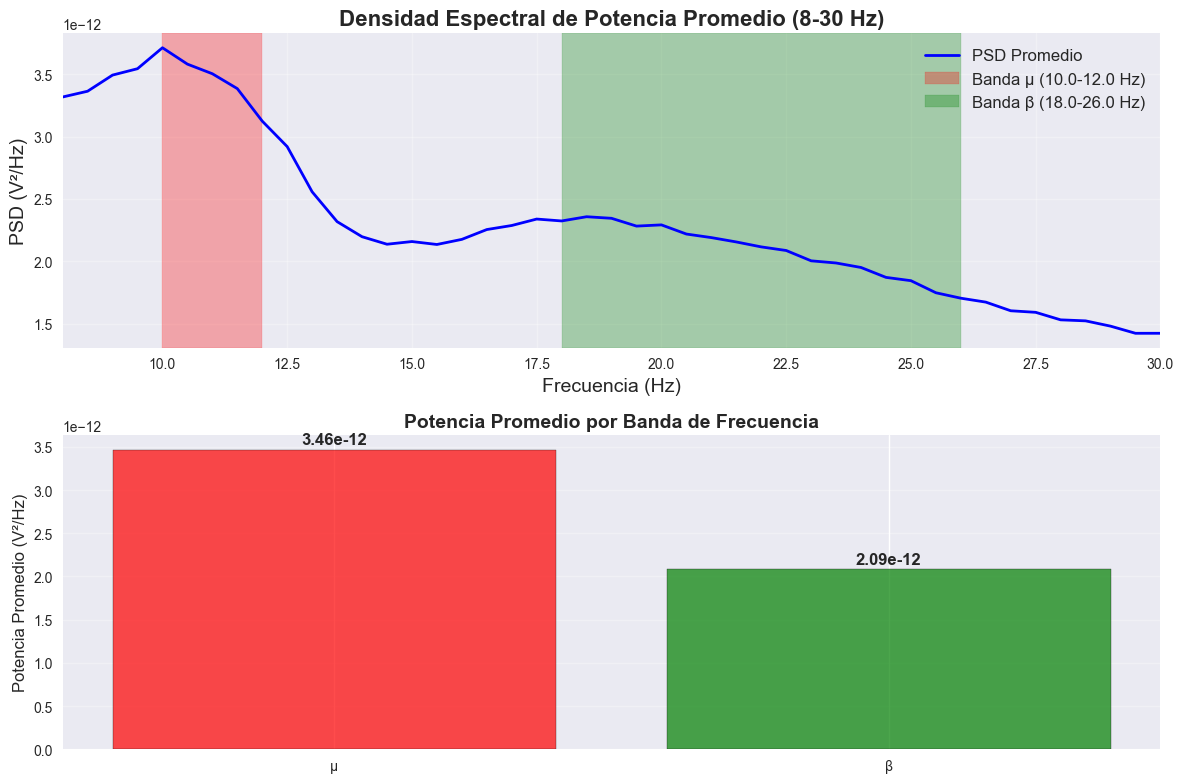

 Guardado: /Users/manueljurado/Downloads/datos_BCI/results/eda/psd_avg.png


In [22]:
# Crear visualización del PSD promedio
plt.figure(figsize=(12, 8))

# PSD promedio sobre todos los canales
psd_mean = psd_filt.mean(axis=0)

# Gráfico principal
plt.subplot(2, 1, 1)
plt.plot(freqs_filt, psd_mean, 'b-', linewidth=2, label='PSD Promedio')
plt.axvspan(MU_BAND[0], MU_BAND[1], alpha=0.3, color='red', label=f'Banda μ ({MU_BAND[0]}-{MU_BAND[1]} Hz)')
plt.axvspan(BETA_BAND[0], BETA_BAND[1], alpha=0.3, color='green', label=f'Banda β ({BETA_BAND[0]}-{BETA_BAND[1]} Hz)')

plt.title('Densidad Espectral de Potencia Promedio (8-30 Hz)', fontsize=16, fontweight='bold')
plt.xlabel('Frecuencia (Hz)', fontsize=14)
plt.ylabel('PSD (V²/Hz)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xlim(LOW_BAND, HIGH_BAND)

# Gráfico de distribución de potencia por banda
plt.subplot(2, 1, 2)
band_names = ['μ', 'β']
band_powers = [mu_power.mean(), be_power.mean()]
colors = ['red', 'green']

bars = plt.bar(band_names, band_powers, color=colors, alpha=0.7, edgecolor='black')
plt.title('Potencia Promedio por Banda de Frecuencia', fontsize=14, fontweight='bold')
plt.ylabel('Potencia Promedio (V²/Hz)', fontsize=12)
plt.grid(True, alpha=0.3, axis='y')

# Añadir valores en las barras
for bar, power in zip(bars, band_powers):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + power*0.01, 
             f'{power:.2e}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()

# Guardar figura
out_png = output_dir / "psd_avg.png"
plt.savefig(out_png, dpi=150, bbox_inches='tight')
plt.show()

print(f" Guardado: {out_png.resolve()}")


## Análisis de Correlación Intercanal

Calculamos la matriz de correlación entre todos los canales EEG:


In [23]:
# Calcular matriz de correlación intercanal
print(" Calculando correlación intercanal...")

# Usar datos concatenados para correlación
data_for_corr = data_concat  # (ch, N*T)
corr = np.corrcoef(data_for_corr)  # (ch, ch)

print(f" Matriz de correlación:")
print(f"  - Dimensiones: {corr.shape}")
print(f"  - Correlación promedio: {corr.mean():.3f}")
print(f"  - Correlación máxima: {corr.max():.3f}")
print(f"  - Correlación mínima: {corr.min():.3f}")

# Estadísticas de correlación
corr_no_diag = corr.copy()
np.fill_diagonal(corr_no_diag, np.nan)  # Excluir diagonal
print(f"  - Correlación promedio (sin diagonal): {np.nanmean(corr_no_diag):.3f}")
print(f"  - Desviación estándar: {np.nanstd(corr_no_diag):.3f}")

# Identificar pares de canales más correlacionados
upper_tri = np.triu(corr, k=1)
max_corr_idx = np.unravel_index(np.argmax(upper_tri), corr.shape)
max_corr_val = corr[max_corr_idx]

print(f"\n Correlaciones más altas:")
print(f"  - Máxima: {ch_names[max_corr_idx[0]]} ↔ {ch_names[max_corr_idx[1]]}: {max_corr_val:.3f}")

# Encontrar top 5 correlaciones
flat_corr = upper_tri.flatten()
top_indices = np.argsort(flat_corr)[-5:]
top_corrs = flat_corr[top_indices]

print(f"  - Top 5 correlaciones:")
for i, (idx, val) in enumerate(zip(top_indices, top_corrs)):
    if not np.isnan(val):
        row, col = np.unravel_index(idx, corr.shape)
        print(f"    {i+1}. {ch_names[row]} ↔ {ch_names[col]}: {val:.3f}")


 Calculando correlación intercanal...
 Matriz de correlación:
  - Dimensiones: (64, 64)
  - Correlación promedio: 0.002
  - Correlación máxima: 1.000
  - Correlación mínima: -0.562
  - Correlación promedio (sin diagonal): -0.014
  - Desviación estándar: 0.347

 Correlaciones más altas:
  - Máxima: O1 ↔ OZ: 0.867
  - Top 5 correlaciones:
    1. AF7 ↔ AF3: 0.822
    2. F2 ↔ F4: 0.827
    3. PZ ↔ P2: 0.828
    4. PO4 ↔ PO8: 0.839
    5. O1 ↔ OZ: 0.867


## Visualización de Correlación Intercanal

Creamos un mapa de calor de la matriz de correlación:


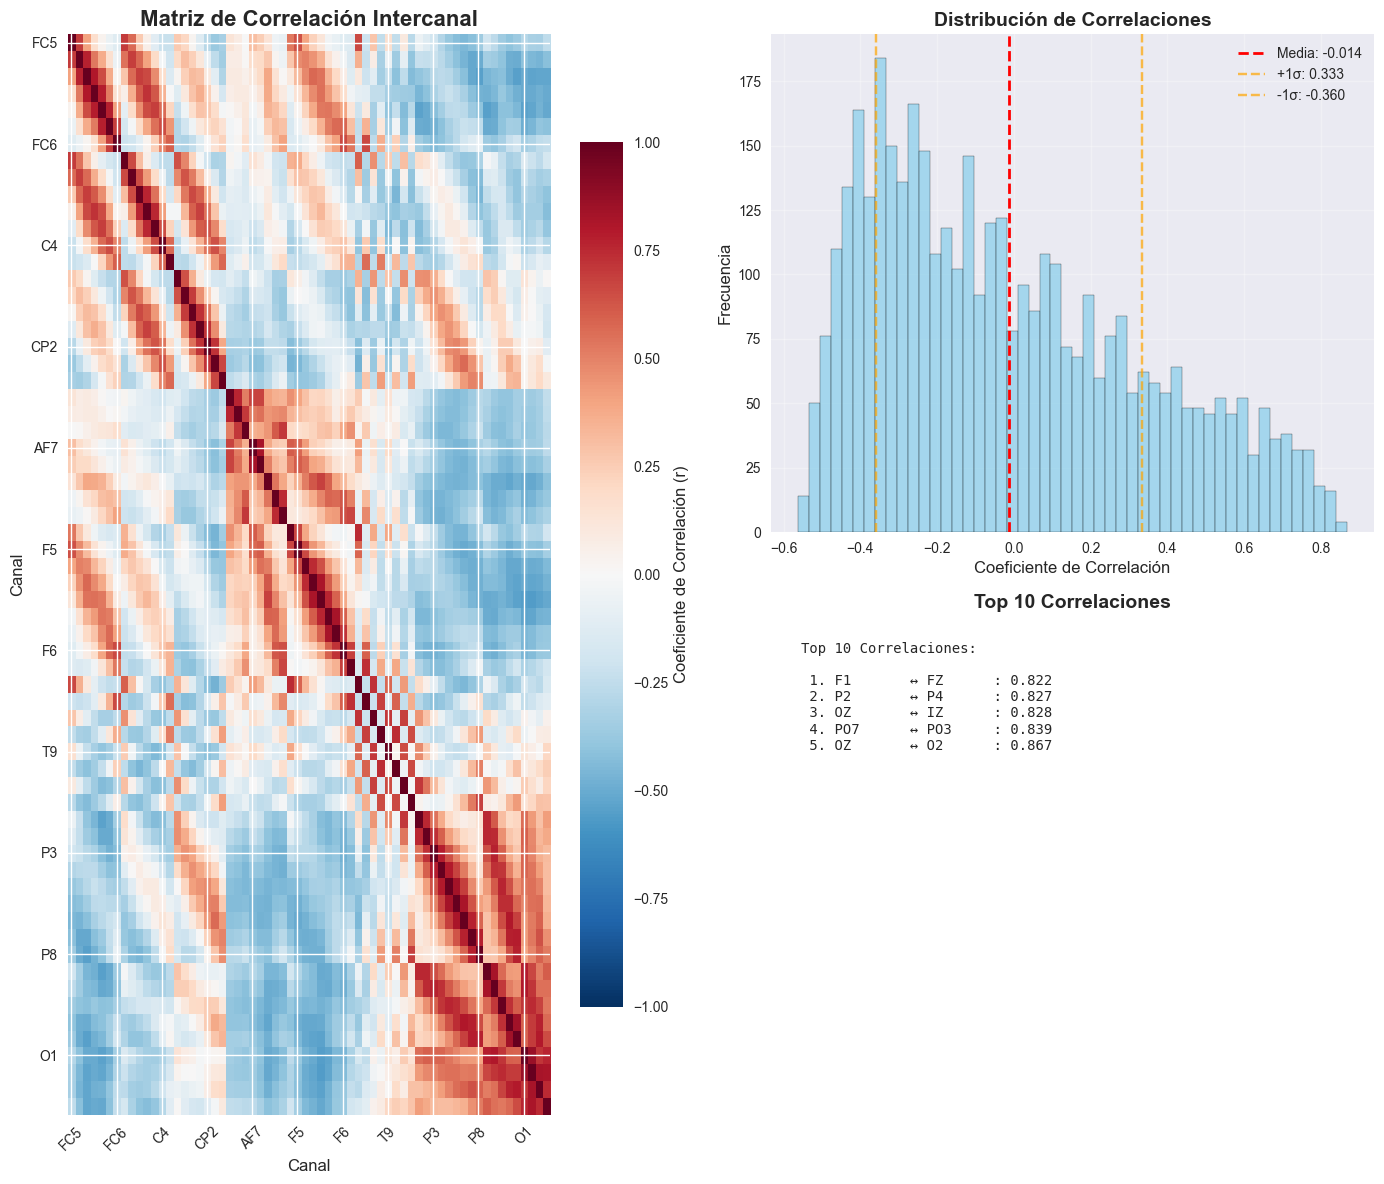

 Guardado: /Users/manueljurado/Downloads/datos_BCI/results/eda/corr_heatmap.png


In [24]:
# Crear mapa de calor de correlación
plt.figure(figsize=(14, 12))

# Mapa de calor principal
plt.subplot(2, 2, (1, 3))
im = plt.imshow(corr, vmin=-1, vmax=1, cmap='RdBu_r', aspect='auto')
plt.title('Matriz de Correlación Intercanal', fontsize=16, fontweight='bold')
plt.xlabel('Canal', fontsize=12)
plt.ylabel('Canal', fontsize=12)

# Añadir colorbar
cbar = plt.colorbar(im, shrink=0.8)
cbar.set_label('Coeficiente de Correlación (r)', fontsize=12)

# Añadir etiquetas de canales cada 10 canales
step = max(1, len(ch_names) // 10)
plt.xticks(range(0, len(ch_names), step), [ch_names[i] for i in range(0, len(ch_names), step)], rotation=45)
plt.yticks(range(0, len(ch_names), step), [ch_names[i] for i in range(0, len(ch_names), step)])

# Histograma de correlaciones
plt.subplot(2, 2, 2)
plt.hist(corr_no_diag.flatten(), bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribución de Correlaciones', fontsize=14, fontweight='bold')
plt.xlabel('Coeficiente de Correlación', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.grid(True, alpha=0.3)

# Estadísticas en el histograma
mean_corr = np.nanmean(corr_no_diag)
std_corr = np.nanstd(corr_no_diag)
plt.axvline(mean_corr, color='red', linestyle='--', linewidth=2, label=f'Media: {mean_corr:.3f}')
plt.axvline(mean_corr + std_corr, color='orange', linestyle='--', alpha=0.7, label=f'+1σ: {mean_corr + std_corr:.3f}')
plt.axvline(mean_corr - std_corr, color='orange', linestyle='--', alpha=0.7, label=f'-1σ: {mean_corr - std_corr:.3f}')
plt.legend()

# Top correlaciones como texto
plt.subplot(2, 2, 4)
plt.axis('off')
plt.title('Top 10 Correlaciones', fontsize=14, fontweight='bold')

# Encontrar top 10 correlaciones
top_10_indices = np.argsort(flat_corr)[-10:]
top_10_corrs = flat_corr[top_10_indices]

text_content = "Top 10 Correlaciones:\n\n"
for i, (idx, val) in enumerate(zip(top_10_indices, top_corrs)):
    if not np.isnan(val):
        row, col = np.unravel_index(idx, corr.shape)
        text_content += f"{i+1:2d}. {ch_names[row]:<8} ↔ {ch_names[col]:<8}: {val:.3f}\n"

plt.text(0.05, 0.95, text_content, transform=plt.gca().transAxes, 
         fontsize=10, verticalalignment='top', fontfamily='monospace')

plt.tight_layout()

# Guardar figura
out_heatmap = output_dir / "corr_heatmap.png"
plt.savefig(out_heatmap, dpi=150, bbox_inches='tight')
plt.show()

print(f" Guardado: {out_heatmap.resolve()}")


## Análisis por Regiones Cerebrales

Analizamos las correlaciones agrupadas por regiones del sistema 10-20:


In [25]:
# Agrupar canales por regiones cerebrales
print(" Analizando correlaciones por regiones cerebrales...")

ch_upper = [c.upper() for c in ch_names]
region_indices: Dict[str, List[int]] = {}

for reg, prefixes in REGION_PREFIXES.items():
    idxs = []
    for i, c in enumerate(ch_upper):
        if any(c.startswith(p) for p in prefixes):
            idxs.append(i)
    region_indices[reg] = idxs
    print(f"  - Región {reg}: {len(idxs)} canales")

# Función para calcular correlación promedio entre regiones
def mean_block(A: np.ndarray, rows: List[int], cols: List[int]) -> float:
    """Calcula la correlación promedio entre dos grupos de canales."""
    if not rows or not cols:
        return np.nan
    sub = A[np.ix_(rows, cols)]
    return float(np.nanmean(sub))

# Calcular correlaciones entre pares de regiones de interés
pairs = [
    ("F", "C"), ("FC", "C"), ("C", "CP"), ("C", "P"), ("F", "P"), ("P", "O")
]

print(f"\n Correlaciones entre regiones:")
lines = []
lines.append("=== Resumen de correlaciones por región ===")
global_mean = float(np.nanmean(corr))
lines.append(f"Global mean r: {global_mean:.3f}")

for a, b in pairs:
    ra, rb = region_indices.get(a, []), region_indices.get(b, [])
    rmean = mean_block(corr, ra, rb)
    lines.append(f"{a}-{b}: mean r = {rmean:.3f}  (n_a={len(ra)}, n_b={len(rb)})")
    print(f"  - {a}-{b}: {rmean:.3f} ({len(ra)}×{len(rb)} canales)")

# Correlaciones intra-región
print(f"\n Correlaciones intra-región:")
for a in ["F", "C", "P", "O"]:
    ra = region_indices.get(a, [])
    rmean = mean_block(corr, ra, ra)
    lines.append(f"{a}-{a}: mean r = {rmean:.3f}  (n={len(ra)})")
    print(f"  - {a}-{a}: {rmean:.3f} ({len(ra)} canales)")

# Guardar resumen
out_txt = output_dir / "corr_region_summary.txt"
out_txt.write_text("\n".join(lines), encoding="utf-8")
print(f"\n Guardado: {out_txt.resolve()}")

# Mostrar resumen completo
print(f"\n Resumen completo:")
for line in lines:
    print(line)


 Analizando correlaciones por regiones cerebrales...
  - Región F: 26 canales
  - Región FC: 7 canales
  - Región C: 14 canales
  - Región CP: 7 canales
  - Región P: 14 canales
  - Región PO: 5 canales
  - Región O: 3 canales

 Correlaciones entre regiones:
  - F-C: -0.046 (26×14 canales)
  - FC-C: 0.155 (7×14 canales)
  - C-CP: 0.318 (14×7 canales)
  - C-P: -0.016 (14×14 canales)
  - F-P: -0.364 (26×14 canales)
  - P-O: 0.566 (14×3 canales)

 Correlaciones intra-región:
  - F-F: 0.287 (26 canales)
  - C-C: 0.305 (14 canales)
  - P-P: 0.539 (14 canales)
  - O-O: 0.867 (3 canales)

 Guardado: /Users/manueljurado/Downloads/datos_BCI/results/eda/corr_region_summary.txt

 Resumen completo:
=== Resumen de correlaciones por región ===
Global mean r: 0.002
F-C: mean r = -0.046  (n_a=26, n_b=14)
FC-C: mean r = 0.155  (n_a=7, n_b=14)
C-CP: mean r = 0.318  (n_a=14, n_b=7)
C-P: mean r = -0.016  (n_a=14, n_b=14)
F-P: mean r = -0.364  (n_a=26, n_b=14)
P-O: mean r = 0.566  (n_a=14, n_b=3)
F-F: mean

In [26]:
# Guardar datos procesados para uso en análisis de wavelets
print("Guardando datos procesados para análisis de wavelets...")

# Crear directorio para datos pre-procesados
shared_data_dir = Path("data/preprocessed")
shared_data_dir.mkdir(parents=True, exist_ok=True)

# Guardar datos principales
np.save(shared_data_dir / "X_data.npy", X)  # Datos concatenados (trials, channels, time)
np.save(shared_data_dir / "ch_names.npy", ch_names)  # Nombres de canales
np.save(shared_data_dir / "sfreq.npy", np.array([sfreq]))  # Frecuencia de muestreo
np.save(shared_data_dir / "data_dimensions.npy", np.array([N, C, T]))  # Dimensiones

# Guardar información de sujetos
subjects_df = pd.DataFrame(subjects_info)
subjects_df.to_csv(shared_data_dir / "subjects_info.csv", index=False)

# Guardar información de regiones
region_info = {
    'region_indices': region_indices,
    'region_prefixes': REGION_PREFIXES
}
import json
with open(shared_data_dir / "region_info.json", 'w') as f:
    json.dump(region_info, f, indent=2)

# Guardar parámetros de configuración
config_params = {
    'LOW_BAND': LOW_BAND,
    'HIGH_BAND': HIGH_BAND,
    'MU_BAND': MU_BAND,
    'BETA_BAND': BETA_BAND,
    'EXPECTED_TRIAL_SEC': EXPECTED_TRIAL_SEC,
    'CANDIDATE_DIRS': CANDIDATE_DIRS
}
with open(shared_data_dir / "config_params.json", 'w') as f:
    json.dump(config_params, f, indent=2)

print(f"Datos compartidos guardados en: {shared_data_dir.resolve()}")
print("Archivos generados:")
print(f"  - X_data.npy: Datos concatenados ({X.shape})")
print(f"  - ch_names.npy: Nombres de canales ({len(ch_names)} canales)")
print(f"  - sfreq.npy: Frecuencia de muestreo ({sfreq} Hz)")
print(f"  - data_dimensions.npy: Dimensiones ({N}, {C}, {T})")
print(f"  - subjects_info.csv: Información de sujetos")
print(f"  - region_info.json: Información de regiones")
print(f"  - config_params.json: Parámetros de configuración")


Guardando datos procesados para análisis de wavelets...
Datos compartidos guardados en: /Users/manueljurado/Downloads/datos_BCI/data/preprocessed
Archivos generados:
  - X_data.npy: Datos concatenados ((880, 64, 1152))
  - ch_names.npy: Nombres de canales (64 canales)
  - sfreq.npy: Frecuencia de muestreo (128.0 Hz)
  - data_dimensions.npy: Dimensiones (880, 64, 1152)
  - subjects_info.csv: Información de sujetos
  - region_info.json: Información de regiones
  - config_params.json: Parámetros de configuración


## Resumen del Análisis EDA

### Archivos Generados

El análisis ha generado los siguientes archivos en el directorio `reports/`:

1. **`psd_bandpower_per_channel.csv`**: Potencia por banda y picos por canal
2. **`psd_avg.png`**: PSD promedio con bandas μ/β destacadas
3. **`corr_heatmap.png`**: Mapa de calor de correlación intercanal
4. **`corr_region_summary.txt`**: Resumen de correlaciones por regiones

### Próximos Pasos

Este análisis EDA proporciona la base para:
- **Análisis de Wavelets**: Las características espectrales identificadas pueden ser analizadas con mayor detalle usando transformadas wavelet
- **Bag of Features**: Las correlaciones intercanales pueden ser utilizadas como características adicionales para clasificación

### Conclusiones Principales

- Se identificaron patrones espectrales en las bandas μ y β
- Se analizaron correlaciones entre regiones cerebrales
- Los datos están listos para análisis más avanzados con wavelets

### Variables Disponibles para Análisis Posteriores

Las siguientes variables están disponibles para usar en el análisis de wavelets:

- `X`: Datos concatenados (trials, channels, time)
- `ch_names`: Nombres de canales
- `sfreq`: Frecuencia de muestreo
- `N, C, T`: Dimensiones de los datos
- `psd_filt`: PSD filtrado por canal
- `freqs_filt`: Frecuencias filtradas
- `corr`: Matriz de correlación intercanal
- `region_indices`: Índices de canales por región
